## Preparing the Data
We will generate a synthetic dataset using the make_classification function from scikit-learn. This dataset will simulate a population with a minority of subjects carrying a disease.

## Pre-test vs. Post-test Analysis
We will fit a logistic regression model to the data and evaluate its performance on a held-out test set. We will compute the positive likelihood ratio to evaluate the usefulness of this classifier as a disease diagnosis tool.

## Cross-validation of Likelihood Ratios
We will assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation.

## Invariance with Respect to Prevalence
We will show that the class likelihood ratios are independent of the disease prevalence and can be extrapolated between populations regardless of any possible class imbalance.

## Preparing the Data
We will generate a synthetic dataset using the make_classification function from scikit-learn. This dataset will simulate a population with a minority of subjects carrying a disease.

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10_000, weights=[0.9, 0.1], random_state=0)
print(f"Percentage of people carrying the disease: {100*y.mean():.2f}%")

Percentage of people carrying the disease: 10.37%


## Pre-test vs. Post-test Analysis
We will fit a logistic regression model to the data and evaluate its performance on a held-out test set. We will compute the positive likelihood ratio to evaluate the usefulness of this classifier as a disease diagnosis tool.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import class_likelihood_ratios
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = LogisticRegression().fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pos_LR, neg_LR = class_likelihood_ratios(y_test, y_pred)

print(f"LR+: {pos_LR:.3f}")

LR+: 12.617


## Cross-validation of Likelihood Ratios
We will assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation.

In [4]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    pos_lr, neg_lr = class_likelihood_ratios(y, y_pred, raise_warning=False)
    return {"positive_likelihood_ratio": pos_lr, "negative_likelihood_ratio": neg_lr}

def extract_score(cv_results):
    lr = pd.DataFrame(
        {
            "positive": cv_results["test_positive_likelihood_ratio"],
            "negative": cv_results["test_negative_likelihood_ratio"],
        }
    )
    return lr.aggregate(["mean", "std"])

estimator = LogisticRegression()
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

estimator = DummyClassifier(strategy="stratified", random_state=1234)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

estimator = DummyClassifier(strategy="most_frequent")
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,NaN,1.0
std,NaN,0.0


## Invariance with Respect to Prevalence
We will show that the class likelihood ratios are independent of the disease prevalence and can be extrapolated between populations regardless of any possible class imbalance.

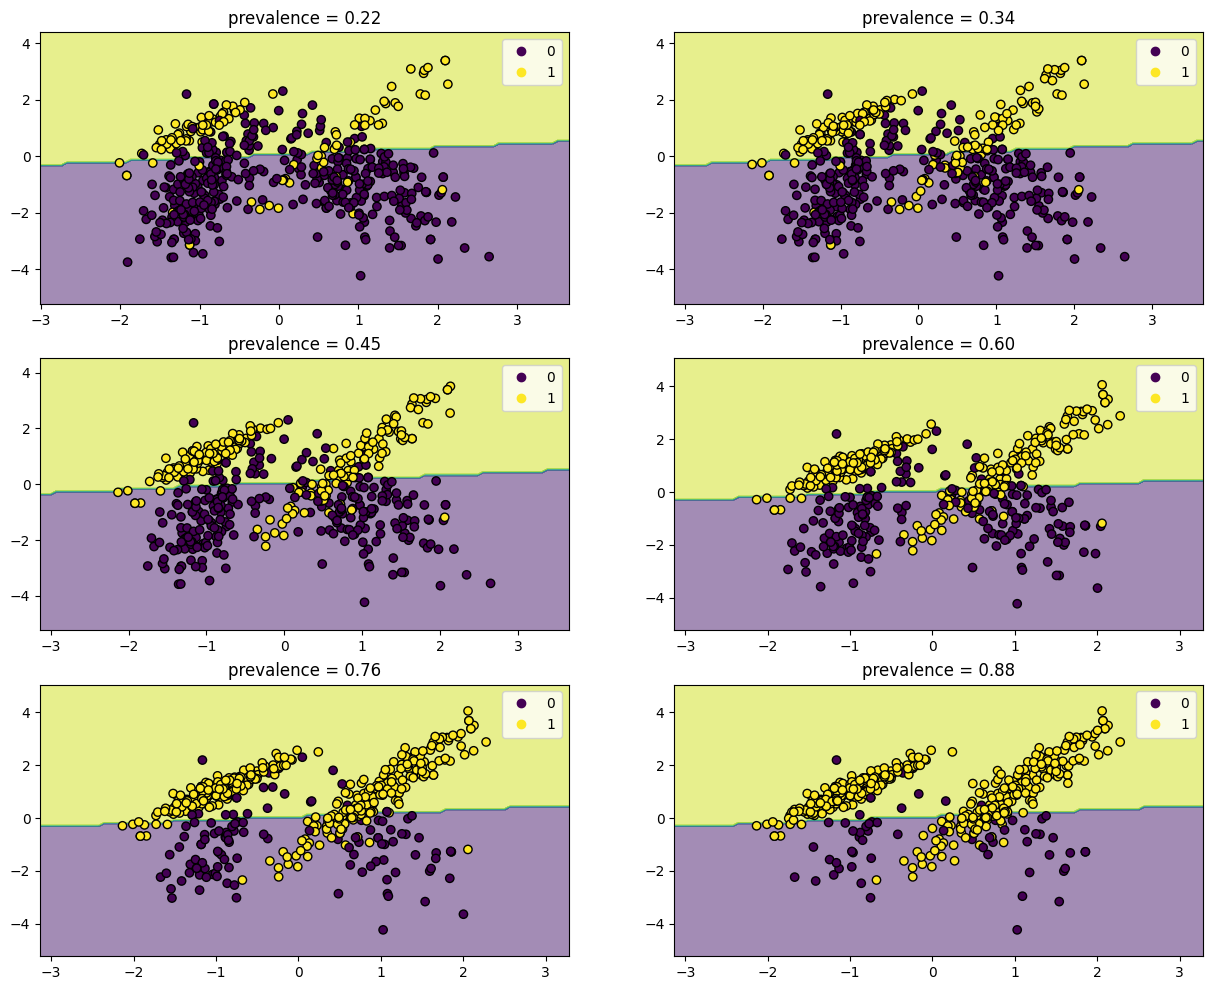

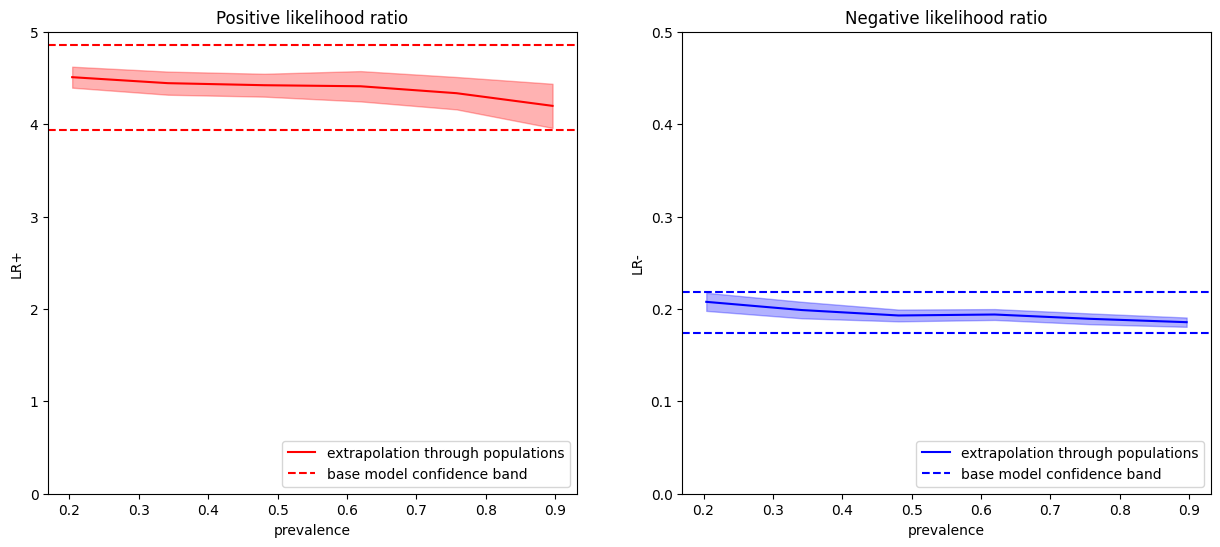

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from collections import defaultdict

populations = defaultdict(list)
common_params = {
    "n_samples": 10_000,
    "n_features": 2,
    "n_informative": 2,
    "n_redundant": 0,
    "random_state": 0,
}
weights = np.linspace(0.1, 0.8, 6)
weights = weights[::-1]

# fit and evaluate base model on balanced classes
X, y = make_classification(**common_params, weights=[0.5, 0.5])
estimator = LogisticRegression().fit(X, y)
lr_base = extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))
pos_lr_base, pos_lr_base_std = lr_base["positive"].values
neg_lr_base, neg_lr_base_std = lr_base["negative"].values

# We will now show the decision boundary for each level of prevalence. Note that
# we only plot a subset of the original data to better assess the linear model
# decision boundary.

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, (n, weight) in zip(axs.ravel(), enumerate(weights)):
    X, y = make_classification(
        **common_params,
        weights=[weight, 1 - weight],
    )
    prevalence = y.mean()
    populations["prevalence"].append(prevalence)
    populations["X"].append(X)
    populations["y"].append(y)

    # down-sample for plotting
    rng = np.random.RandomState(1)
    plot_indices = rng.choice(np.arange(X.shape[0]), size=500, replace=True)
    X_plot, y_plot = X[plot_indices], y[plot_indices]

    # plot fixed decision boundary of base model with varying prevalence
    disp = DecisionBoundaryDisplay.from_estimator(
        estimator,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolor="k")
    disp.ax_.set_title(f"prevalence = {y_plot.mean():.2f}")
    disp.ax_.legend(*scatter.legend_elements())

def scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=100):
    results_for_prevalence = defaultdict(list)
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(
            np.arange(X.shape[0]), size=X.shape[0], replace=True
        )
        for key, value in scoring(
            estimator, X[bootstrap_indices], y[bootstrap_indices]
        ).items():
            results_for_prevalence[key].append(value)
    return pd.DataFrame(results_for_prevalence)

results = defaultdict(list)
n_bootstrap = 100
rng = np.random.default_rng(seed=0)

for prevalence, X, y in zip(
    populations["prevalence"], populations["X"], populations["y"]
):
    results_for_prevalence = scoring_on_bootstrap(
        estimator, X, y, rng, n_bootstrap=n_bootstrap
    )
    results["prevalence"].append(prevalence)
    results["metrics"].append(
        results_for_prevalence.aggregate(["mean", "std"]).unstack()
    )

results = pd.DataFrame(results["metrics"], index=results["prevalence"])
results.index.name = "prevalence"
results

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
results["positive_likelihood_ratio"]["mean"].plot(
    ax=ax1, color="r", label="extrapolation through populations"
)
ax1.axhline(y=pos_lr_base + pos_lr_base_std, color="r", linestyle="--")
ax1.axhline(
    y=pos_lr_base - pos_lr_base_std,
    color="r",
    linestyle="--",
    label="base model confidence band",
)
ax1.fill_between(
    results.index,
    results["positive_likelihood_ratio"]["mean"]
    - results["positive_likelihood_ratio"]["std"],
    results["positive_likelihood_ratio"]["mean"]
    + results["positive_likelihood_ratio"]["std"],
    color="r",
    alpha=0.3,
)
ax1.set(
    title="Positive likelihood ratio",
    ylabel="LR+",
    ylim=[0, 5],
)
ax1.legend(loc="lower right")

ax2 = results["negative_likelihood_ratio"]["mean"].plot(
    ax=ax2, color="b", label="extrapolation through populations"
)
ax2.axhline(y=neg_lr_base + neg_lr_base_std, color="b", linestyle="--")
ax2.axhline(
    y=neg_lr_base - neg_lr_base_std,
    color="b",
    linestyle="--",
    label="base model confidence band",
)
ax2.fill_between(
    results.index,
    results["negative_likelihood_ratio"]["mean"]
    - results["negative_likelihood_ratio"]["std"],
    results["negative_likelihood_ratio"]["mean"]
    + results["negative_likelihood_ratio"]["std"],
    color="b",
    alpha=0.3,
)
ax2.set(
    title="Negative likelihood ratio",
    ylabel="LR-",
    ylim=[0, 0.5],
)
ax2.legend(loc="lower right")

plt.show()

## Summary
In this lab, we have learned how to compute the positive and negative likelihood ratios to assess the predictive power of a binary classifier. These metrics are independent of the proportion between classes in the test set, making them very useful when the available data for a study has a different class proportion than the target application. We also learned how to assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation and how to show that the class likelihood ratios are independent of the disease prevalence.